# ``ConvNet2d`` Demo

To use this demo, build the conda env defined in ``requirements-dev.conda.yaml``.

The ``torch_tools.ConvNet2d`` model is—believe it or not—a two-dimensional convolutional neural network. The model consists of three modular components:

- an encoder, which can be optionally set to any of ``torchvision``'s ResNet or VGG models.
- an adaptive pooling layer, which can be optionally set to adaptive average pooling, max pooling, or a concatenation of both.
- a fully-connected final block, which is simply a customisable instance of ``torch_tools.FCNet``.

The main useful features of the model are:
- the ability to set the number of input channels images should have at instantiation, which you cannot do with out-of-the-box ``torchvision`` models.
    - note—this comes with the caveat that freezing the pretrained weights becomes pointless, as the first ``conv2d`` layer of the encoder is overloaded to account for the different number of channels.
- the ability to load the model with ``torchvision``'s ImageNet-pretrained weights, and do transfer learning with/without the pretrained weights frozen.

## Classifying handwritten digits — MNIST

The MNIST dataset contains greyscale images of `(28,28)` pipxels containing handwritten digits between zero and nine. It is very easy to access the MNIST data through ``torchvision``—so much so that we don't even need to use the custom ``torch_tools.DataSet`` class.

So, let's get some digits!

### Demo env
Remember: the demo env requirements file—``demo-requirements.conda.yaml``—is different from the standard ``requirements.conda.yaml``. See ``README.md``.

In [1]:
from torchvision.datasets import MNIST
from torch import eye
from torchvision.transforms import Compose, ToTensor, RandomRotation

import matplotlib.pyplot as plt

train_set = MNIST(
    "~/mnist_data/",
    download=True,
    train=True,
    transform=Compose([ToTensor(), lambda x: x.repeat(3, 1, 1), RandomRotation(180.0)]),
    target_transform=Compose([lambda x: eye(10)[x]]),
)

valid_set = MNIST(
    "~/mnist_data/",
    download=True,
    train=False,
    transform=Compose([ToTensor(), lambda x: x.repeat(3, 1, 1)]),
    target_transform=Compose([lambda x: eye(10)[x]]),
)

print(len(train_set), len(valid_set))

60000 10000


Since we have done quite a few things here, let's break them down.

- The ``transform`` argument:
  - we supply a ``torchvision.transfroms.Compose`` object, which simply lets you chain callable objects to modify the images.
  - the first thing in the ``Compose`` is a ``torchvision.transforms.ToTensor``, which converts PIL images (or numpy image-like arrays) to ``torch.Tensor``s.
  - the second thing is the lambda function, which simply repeats the greyscale ``Tensor`` three times along the channel dimension. We do this because we are going to use a pretrained model which requires three input channels.
- The ``target_transform`` argument:
  - The target for each image is simply encoded as an integer. ``0`` means the image contains a zero, ``1`` means the image contains a one, etc. We convert these indices to one-hot encoded vectors with the lambda function supplued to ``target_transfrom``.

Let's look at a single example.

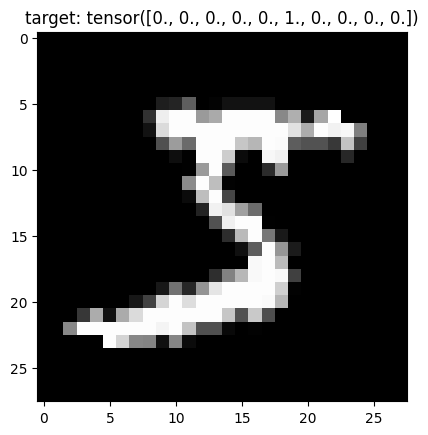

In [2]:
img, target = train_set[0]

plt.imshow(img.permute(1, 2, 0))
plt.title(f"target: {target}")
plt.show()

This example is clearly a five, and the target is a one-hot vector encoding the fact that the ground truth is a five.

As before, we now wrap the datasets in ``torch.utils.data.DataLoader``.

In [3]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

As before, we need a model, optimiser and a loss function.

In [4]:
from torch_tools import ConvNet2d
from torch.cuda import is_available

DEVICE = "cuda" if is_available() else "cpu"

model = ConvNet2d(
    out_feats=10,
    pretrained=True,
    encoder_style="mobilenet_v3_large",
    fc_net_kwargs={"input_dropout": 0.1},
).to(DEVICE)
print(model)

ConvNet2d(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias

Here, we have instantiated a resnet18, with ImageNet-pretrained weights and applied a dropout to the classification layer.

Now, lets set up a loss function and optimiser.

In [5]:
from torch.nn import BCELoss
from torch.optim import Adam

loss_func = BCELoss(reduction="sum")
optimiser = Adam(model.parameters(), lr=1e-4)

And now, the training and validation loops.

In [6]:
from torch import no_grad


def train_one_epoch(
    train_loader: DataLoader,
    loss_func: BCELoss,
    optimiser: Adam,
    model: ConvNet2d,
    frozen_encoder: bool = True,
):
    """Train the model for a single epoch.

    Parameters
    ----------
    train_loader : DataLoader
        A data loader supplying the training data.
    loss_func : BCELoss
        The loss function.
    optimiser : Adam
        Optimiser to fit the model with.
    model : ConvNet2d
        Classification model.
    frozen_encoder : bool
        Bool determining whether the encoder's weights should be frozen or not.

    Returns
    -------
    mean_loss : float
        Mean loss per item.
    accuracy : float
        Fraction of inputs correctly classified.

    """
    model.train()
    running_loss = 0.0
    correct = 0
    for batch, targets in train_loader:
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        optimiser.zero_grad()

        preds = model(batch, frozen_encoder=frozen_encoder).softmax(dim=1)

        loss = loss_func(preds, targets)

        loss.backward()

        optimiser.step()

        running_loss += loss.item()

        correct += (
            (preds.argmax(dim=1).detach().cpu() == targets.cpu().argmax(dim=1))
            .sum()
            .item()
        )

    mean_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)

    return mean_loss, accuracy


@no_grad()
def validate_one_epoch(
    valid_loader: DataLoader,
    loss_func: BCELoss,
    model: ConvNet2d,
):
    """Validate the model for a single epoch.

    Parameters
    ----------
    valid_loader : DataLoader
        Validation data loader.
    loss_func : BCELoss
        Loss function
    model : ConvNet2d
        Classification model.

    Returns
    -------
    mean_loss : float
        The mean loss per item.
    accuracy : float
        The fraction of correctly classified inputs.

    """
    model.eval()
    running_loss = 0.0
    correct = 0
    for batch, targets in valid_loader:
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        preds = model(batch).softmax(dim=1)

        loss = loss_func(preds, targets)

        running_loss += loss.item()

        correct += (
            (preds.argmax(dim=1).detach().cpu() == targets.argmax(dim=1).cpu())
            .sum()
            .item()
        )

    mean_loss = running_loss / len(valid_loader.dataset)
    accuracy = correct / len(valid_loader.dataset)

    return mean_loss, accuracy

Now we can train the model.

Note, for the first four training epochs we set the frozen encoder argument to ``True``, and then for the final two epochs we set it to ``False``. Take a look at the plots and see how this switching affects the performance metrics.

In [7]:
num_epochs = 10
freeze_epochs = 4

training_loss, validation_loss = [], []
training_acc, validation_acc = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        train_loader,
        loss_func,
        optimiser,
        model,
        frozen_encoder=epoch < freeze_epochs,
    )
    valid_loss, valid_acc = validate_one_epoch(valid_loader, loss_func, model)

    training_loss.append(train_loss)
    training_acc.append(train_acc)

    validation_loss.append(valid_loss)
    validation_acc.append(valid_acc)

Now let's plot some simple performance metrics.

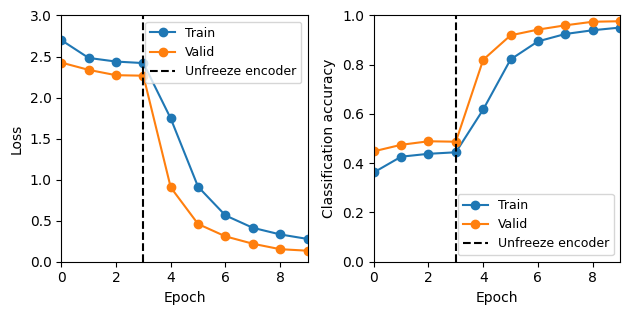

In [12]:
from numpy import diff

fig, axes = plt.subplots(1, 2)

axes[0].plot(training_loss, "-o", label="Train")
axes[0].plot(validation_loss, "-o", label="Valid")

axes[1].plot(training_acc, "-o", label="Train")
axes[1].plot(validation_acc, "-o", label="Valid")


for axis in axes.ravel():
    axis.set_xlim(left=0, right=len(training_loss) - 1)
    axis.set_xlabel("Epoch")

axes[0].set_ylim(bottom=0.0, top=3.0)
axes[1].set_ylim(bottom=0.0, top=1.0)

for axis in axes.ravel():
    axis.plot(
        [freeze_epochs - 1] * 2,
        axis.get_ylim(),
        "--k",
        label="Unfreeze encoder",
    )
    axis.set_aspect(
        diff(axis.get_xlim()) / diff(axis.get_ylim()),
    )
    axis.legend(fontsize=9)

axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Classification accuracy")


fig.tight_layout()

Note the sudden boost in performance when we *unfreeze* the encoder. You might ask what was the point in freezing the encoder if the performance is suddenly boosted by unfreezing it. The short answer is that it really depends on the problem at hand, and training with the encoder frozen is vastly computationally cheaper than fitting the entire model.

You might also consider that loading the encoder with pretrained weights, while the fully connected block is loaded with randomly initialised weights, is a less effective way of capitalising on the pretained weights in comparison to freezing the encoder (at least initially).

For other problems, you may wish to pretrain the encoder yourself, so it is useful to have this functionality built in.

## Visualilising the features with TSNE

In [9]:
from torch import concat

model.eval()

feats, tgts = [], []

for batch, targets in valid_loader:

    with no_grad():
        feats.append(model.get_features(batch.to(DEVICE)).cpu())

    tgts.append(targets.argmax(dim=1))

feats = concat(feats, dim=0).numpy()
tgts = concat(tgts, dim=0).numpy()

In [10]:
from pandas import DataFrame

from sklearn.manifold import TSNE

data = DataFrame()
data["target"] = tgts

data[["x", "y"]] = TSNE(n_components=2).fit_transform(feats)

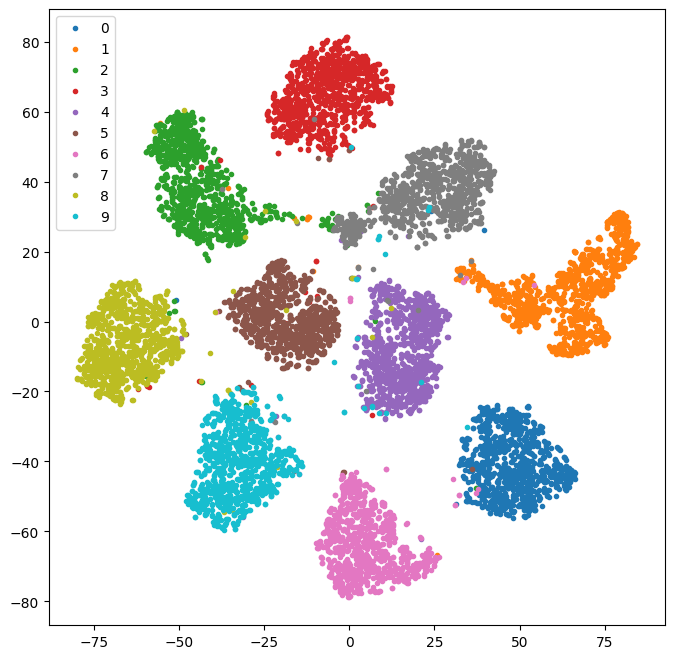

In [14]:
figure, axis = plt.subplots(1, 1, figsize=(8, 8))

for number, frame in data.groupby("target"):
    axis.plot(frame.x, frame.y, ".", label=number)

axis.set_aspect(diff(axis.get_xlim()) / diff(axis.get_ylim()))

axis.legend()